In [8]:
import glob, re
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import time as ttime
import h5py
import pickle

import pandas as pd
from scipy import stats

import IPython as ip

In [9]:
# load the data

import h5py

f = h5py.File('/nsls2/data/projects/ldrd-22-031-blopt/tes_data/220812/kb_gs_3keV.h5', 'r')

images   = f['images'][:]
images  -= images.mean(axis=0)[None,:,:]
metadata = f['metadata'][:]

# these two lines downsample by a factor of 2, 
images = 0.5 * (images[:,0::2] + images[:,1::2])
images = 0.5 * (images[:,:,0::2] + images[:,:,1::2])

f.close()

nf, nx, ny = images.shape
nf, nx, ny

(28561, 240, 352)

In [10]:
# figure out the shape of the grid scan

bin_index  = np.zeros(metadata.shape, dtype=int)
GRID_SHAPE = []
grid_edge_list = []

for i, _mps in enumerate(metadata.T):

    _mp_mids = np.linspace(_mps.min(), _mps.max(), len(np.unique(_mps.round(2))))
    delta_mp = np.gradient(_mp_mids).mean()
    GRID_SHAPE.append(len(_mp_mids))
    _mp_bins = np.append(_mp_mids[0] - 0.5 * delta_mp, _mp_mids + 0.5 * delta_mp)
    
    bin_index[:, i] = np.digitize(_mps, _mp_bins) - 1
    grid_edge_list.append(_mp_mids)
    
MOTOR_POSITIONS = metadata.reshape(*GRID_SHAPE,4,order='C')
GRID_SHAPE

[13, 13, 13, 13]

In [11]:
# how to parse some statistics from images

def get_beam_stats(im, thresh=np.exp(-2), area_method='convex'):


    W = im.copy()
    W[W < thresh * W.max()] = 0

    nx, ny = im.shape
    I, J = np.meshgrid(np.arange(nx), np.arange(ny), indexing='ij')

    cx = np.sum(W * I) / np.sum(W)
    cy = np.sum(W * J) / np.sum(W)
    
    wx = np.sum(W * np.square(I-cx)) / np.sum(W)
    wy = np.sum(W * np.square(J-cy)) / np.sum(W)

    from skimage import measure
    contours = measure.find_contours(im, thresh * im.max())
    contour  = contours[np.argmax([len(_) for _ in contours])]
    #cx, cy   = contour.mean(axis=0)
    #wx, wy   = contour.ptp(axis=0)
    peak     = im.max()
    hull     = sp.spatial.qhull.ConvexHull(contour)
    if area_method == 'concave':
        area = get_concave_area(contour)
    else: 
        area = hull.volume

    I, J = np.meshgrid(np.arange(int(np.maximum(cx-0.5*wx,0)),
                                 int(np.minimum(cx+0.5*wx,nx-1))), 
                       np.arange(int(np.maximum(cy-0.5*wy,0)),
                                 int(np.minimum(cy+0.5*wy,ny-1))), indexing='ij')

    in_contour = True
    for eq in hull.equations:
        in_contour &= (eq[:-1][:,None,None]*np.r_[I[None],J[None]]).sum(axis=0) + eq[-1] <= 1e-12
    flux = im[I,J][in_contour].sum()

    return cx, cy, wx, wy, peak, flux, area, contour

%time get_beam_stats(images[0])[:-1]


CPU times: user 7.08 ms, sys: 4.05 ms, total: 11.1 ms
Wall time: 9.73 ms


(116.65527620805118,
 161.4475993894332,
 0.9826314654017632,
 3.087853093993166,
 591.6667,
 1603.2688,
 32.49465041603218)

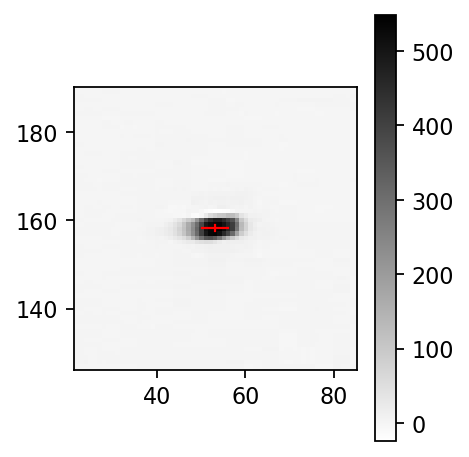

In [12]:
i  = 202

fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=160, sharex=True, sharey=True, tight_layout=True)

im = images[i]

cx, cy, wx, wy, peak, flux, area, contour = get_beam_stats(im, thresh=0.5)

ri = np.max([32, 1.1*0.5*wx, 1.1*0.5*wy])

intensity = ax.imshow(im.T, cmap='gray_r')

plt.plot([cx-0.5*wx,cx+0.5*wx],[cy,cy],lw=1,c='r')
plt.plot([cx,cx],[cy-0.5*wy,cy+0.5*wy],lw=1,c='r')

ax.set_xlim(cx-ri,cx+ri)
ax.set_ylim(cy-ri,cy+ri)
fig.colorbar(mappable=intensity)

In [13]:
# compute beam statistics for every image (may take a bit)

beam_stats = np.empty((nf,8))

for i, im in enumerate(images):
    
    cx, cy, wx, wy, peak, flux, area, contour = get_beam_stats(im, thresh=0.5)
    
    closed = np.sqrt(np.sum(np.square(contour[0] - contour[-1]))) < 4
    
    beam_stats[i] = cx, cy, wx, wy, peak, flux, area, closed
    
    if (i+1) % 100 == 0: 
        print(i+1)
        print(beam_stats[i])
        ip.display.clear_output(wait=True)
    
stats = pd.DataFrame(beam_stats, columns=['cx','cy','wx','wy','peak','flux','area','closed'])

stats.loc[stats.closed < 0.5, 'wx'] = nx
stats.loc[stats.closed < 0.5, 'wy'] = ny

stats['log_wx']   = np.log(stats['wx'])
stats['log_wy']   = np.log(stats['wy'])

stats.describe()

/srv/conda/envs/notebook/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,cx,cy,wx,wy,peak,flux,area,closed,log_wx,log_wy
count,28561.000000,28561.000000,28561.000000,28561.000000,28561.000000,28561.000000,28561.000000,28561.000000,2.856100e+04,28561.000000
mean,96.097518,180.430753,7.964757,30.602561,371.272052,7686.128282,88.496722,0.984804,-inf,2.645710
std,37.309110,79.055783,29.222377,48.888467,143.181507,5625.280863,57.236204,0.122332,NaN,1.287812
min,17.484049,17.339860,0.000000,1.024763,50.778564,0.000000,14.433755,0.000000,-inf,0.024462
25%,68.796523,121.706884,0.869764,4.929920,252.419128,3214.581787,43.885770,1.000000,-1.395329e-01,1.595323
50%,96.441552,177.990145,2.584761,15.926290,377.101929,6332.638672,72.834492,1.000000,9.496329e-01,2.767971
75%,124.392252,239.296686,6.621709,38.409982,507.121948,11987.011719,118.669107,1.000000,1.890353e+00,3.648317
max,173.358189,347.840298,240.000000,352.000000,632.161987,23913.957031,378.958965,1.000000,5.480639e+00,5.863631


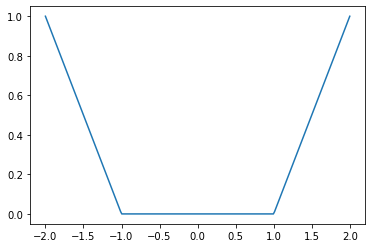

In [14]:
# make a penalizing function for near the image edges

bounder = lambda x, x_min, x_max : np.exp(1e1*(np.abs(x)-1))

def bounder(x, x_min, x_max):
    
    wid, mid = .5 * (x_max - x_min), .5 * (x_min + x_max)
    
    return np.maximum(0,np.abs((x - mid) / wid) - 1)

_ = np.linspace(-2,2,256)


plt.plot(_, bounder(_, -1, 1))
#plt.yscale('log')
#plt.ylim(1e-6,1e1)

In [15]:
# define the "best" beam (as small as possible, within the middle 80% of the image)

stats['shape_fitness'] = - stats.area
stats['bound_fitness'] = - 1e6 * (bounder(stats.cx, nx/10, 9*nx/10) + bounder(stats.cy, ny/10, 9*ny/10))

stats['fitness'] = stats['shape_fitness'] + stats['bound_fitness']

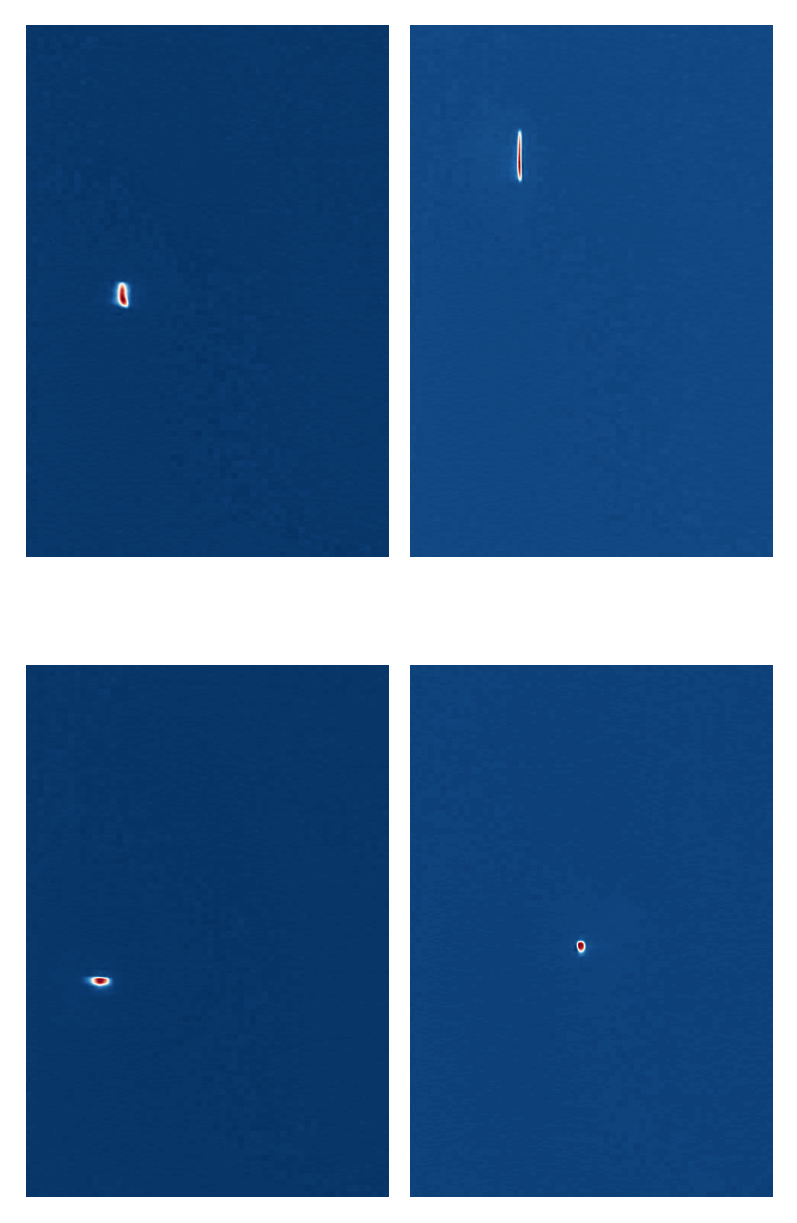

In [18]:
# here are some beams of different fitnesses

y  = stats.fitness
qs = [60,70,80,95]

fig, axes = plt.subplots(2,2,figsize=(3,5),dpi=256,constrained_layout=True,)

i_list = [np.argmin(np.abs(yq-y)) for yq in np.percentile(y,q=qs)]

for iim, ax in zip(i_list, axes.ravel()):
    ax.imshow(sp.ndimage.zoom(images[iim].T,2),cmap='RdBu_r')
    ax.set_axis_off()


In [23]:
# make a rapid fitness interpolator
fitness_LRGI = sp.interpolate.RegularGridInterpolator(grid_edge_list, 
                                                      stats.fitness.values.reshape(*GRID_SHAPE), 
                                                      bounds_error=False, fill_value=-np.inf, method='linear')


In [24]:
# make a loss function that scipy likes

bounds = [[metadata[:,imp].min(), metadata[:,imp].max()] for imp in range(4)]

x_hist, y_hist = [], []

def get_loss(mps):
    
    global x_hist, y_hist
    x_hist.append(mps)
    res  = fitness_LRGI(mps)[0]
    loss = -res
    y_hist.append(loss)
    
    return loss

In [33]:
# define the fitting paramters

methods = ['Nelder-Mead', 'Powell', 'CG', 'L-BFGS-B', 'TNC', 'SLSQP']

n_methods = len(methods)

mfev = 256

n_trials = 64

sobol = sp.stats.qmc.Sobol(d=4)
sobol.reset()

mp_min = np.percentile(metadata, q=25, axis=0)
mp_max = np.percentile(metadata, q=75, axis=0)

INIT_MPS = metadata[np.random.choice(np.arange(nf), size=n_trials)]* (mp_max - mp_min) + mp_min

INIT_MPS = sobol.random(n=n_trials) * (mp_max - mp_min) + mp_min
INIT_MPS 

array([[2.30554752, 3.33450831, 2.54082726, 4.23455574],
       [2.27571483, 3.3862284 , 2.44518416, 4.28876399],
       [2.25852126, 3.29079799, 2.50802002, 4.25986865],
       [2.34139381, 3.34221719, 2.47800323, 4.31328118],
       [2.32053463, 3.31475273, 2.46913488, 4.30916428],
       [2.25320804, 3.36225518, 2.52390831, 4.2672571 ],
       [2.2923625 , 3.3199387 , 2.48632825, 4.28370102],
       [2.31272846, 3.36930095, 2.50672599, 4.24259729],
       [2.31533649, 3.29646837, 2.49318128, 4.27079771],
       [2.28262522, 3.34904743, 2.50066372, 4.30547679],
       [2.2498544 , 3.32885054, 2.46348727, 4.24550307],
       [2.32945459, 3.3793863 , 2.5303459 , 4.28094134],
       [2.33862531, 3.32676799, 2.51367635, 4.29777212],
       [2.26841862, 3.37497076, 2.47157436, 4.22540074],
       [2.27930179, 3.30791006, 2.53398373, 4.32321702],
       [2.29639385, 3.35659645, 2.45125592, 4.25007891],
       [2.30093902, 3.30534027, 2.49564918, 4.2855973 ],
       [2.28071349, 3.35284712,

In [ ]:
# do fits for different initial positions

method_res = np.zeros((n_methods, n_trials, mfev))

for i_method, method in enumerate(methods):

    for i in range(n_trials):

        x_hist, y_hist = [], []

        init_mps = INIT_MPS[i]
        #res = sp.optimize.differential_evolution(get_loss, bounds=bounds, x0=init_mps, maxiter=mfev)
        res = sp.optimize.minimize(get_loss, bounds=bounds, x0=init_mps, method=method, options={'maxfun':mfev}, tol=1e-9)

        losses   = [-fitness_LRGI(mp)[0] for mp in x_hist]
        cum_mins = [np.min(losses[:i]) for i in range(1,mfev+1)]

        method_res[i_method,i,:len(cum_mins)] = cum_mins

        print(f'({method}) iter # {i:>02} : {get_loss(init_mps):.03f} -> {res.fun:.03f}'); ip.display.clear_output(wait=True)


(L-BFGS-B) iter # 10 : 44.482 -> 18.336


In [ ]:
# plot results

spa = 2

nx_ax = int(np.ceil(n_methods / 3))
ny_ax = int(np.ceil(n_methods) / nx_ax)

fig, axes = plt.subplots(nx_ax, ny_ax, figsize=(ny_ax*spa, nx_ax*spa), dpi=256, constrained_layout=True, sharex=True, sharey=True)

max_fit =  -stats.fitness.max()

for i_ax, (method, ax) in enumerate(zip(methods, axes.ravel())):

    l, m, u = np.nanpercentile(method_res[i_ax], q=[5,50,95], axis=0)

    ax.fill_between(np.arange(mfev),l,u,alpha=0.25,lw=0,color='tomato')
    
    ax.plot(method_res[i_ax].T, lw=1e-2, c='k')

    ax.plot(np.arange(mfev),m,color='tomato')
    
    ax.set_title(method, fontsize=10)
    
    ax.plot([0,mfev],[max_fit, max_fit], ls=':')
    
    ax.set_ylim(0,400)
    
for ax in axes[:,0]: ax.set_ylabel('beam area (pixels)', fontsize=10)
for ax in axes[1]: ax.set_xlabel('func_evals', fontsize=10)

